In [4]:
!pip install --upgrade datasets Sastrawi scikit-learn -q

In [5]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import re
import string

In [6]:
import joblib
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
dataset = load_dataset("bwbayu/automatic_essay_scoring")
print(dataset)

train_data = pd.DataFrame(dataset["train"])
val_data = pd.DataFrame(dataset["validation"])
test_data = pd.DataFrame(dataset["test"])

print(train_data.head())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/777 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/2.28M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15682 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4705 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2019 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'reference_answer', 'answer', 'score', 'dataset', 'max_length1', 'normalized_score', '__index_level_0__'],
        num_rows: 15682
    })
    validation: Dataset({
        features: ['question', 'reference_answer', 'answer', 'score', 'dataset', 'max_length1', 'normalized_score', '__index_level_0__'],
        num_rows: 4705
    })
    test: Dataset({
        features: ['question', 'reference_answer', 'answer', 'score', 'dataset', 'max_length1', 'normalized_score', '__index_level_0__'],
        num_rows: 2019
    })
})
                                            question  \
0  Sebutkan 5 manfaat olahraga bagi tubuh. (Terma...   
1  Sebutkan 7 sikap orang tua agar anak tidak sal...   
2  Sebutkan 6 cara belanja (shopping) yang baik d...   
3  Sebutkan 5 partai yang biasa dilombakan dalam ...   
4  Sebutkan 6 cara belanja (shopping) yang baik d...   

                                    reference_answer  \
0  -Mengurangi str

In [8]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stemmer = StemmerFactory().create_stemmer()
stop_factory = StopWordRemoverFactory()
stopwords = set(stop_factory.get_stop_words())

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\d+", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    tokens = [t for t in text.split() if t not in stopwords]
    stemmed = " ".join([stemmer.stem(t) for t in tokens])
    return stemmed

print(preprocess_text("Saya sedang belajar menulis ESSAY untuk tugas kuliah di Kampus."))

sedang ajar tulis essay tugas kuliah kampus


In [9]:
def combine_context(row):
    return f"{row['question']} {row['reference_answer']}"

train_data["context"] = train_data.apply(combine_context, axis=1)
val_data["context"] = val_data.apply(combine_context, axis=1)
test_data["context"] = test_data.apply(combine_context, axis=1)

train_data["answer_clean"] = train_data["answer"].apply(preprocess_text)
train_data["context_clean"] = train_data["context"].apply(preprocess_text)

val_data["answer_clean"] = val_data["answer"].apply(preprocess_text)
val_data["context_clean"] = val_data["context"].apply(preprocess_text)

test_data["answer_clean"] = test_data["answer"].apply(preprocess_text)
test_data["context_clean"] = test_data["context"].apply(preprocess_text)

In [10]:
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(train_data["context_clean"].tolist() + train_data["answer_clean"].tolist())

def cosine_similarity_score(contexts, answers):
    sims = []
    for c, a in zip(contexts, answers):
        c_vec = vectorizer.transform([c]).toarray().reshape(-1)
        a_vec = vectorizer.transform([a]).toarray().reshape(-1)
        sim = 1 - cosine(c_vec, a_vec)
        if np.isnan(sim):
            sim = 0.0
        sims.append(sim)
    return np.array(sims)

train_pred = cosine_similarity_score(train_data["context_clean"], train_data["answer_clean"])
val_pred = cosine_similarity_score(val_data["context_clean"], val_data["answer_clean"])
test_pred = cosine_similarity_score(test_data["context_clean"], test_data["answer_clean"])

/usr/local/lib/python3.12/dist-packages/scipy/spatial/distance.py:682: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


In [11]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

train_mae = mean_absolute_error(train_data["normalized_score"], train_pred)
train_rmse = rmse(train_data["normalized_score"], train_pred)

val_mae = mean_absolute_error(val_data["normalized_score"], val_pred)
val_rmse = rmse(val_data["normalized_score"], val_pred)

test_mae = mean_absolute_error(test_data["normalized_score"], test_pred)
test_rmse = rmse(test_data["normalized_score"], test_pred)

print("=== Baseline TF-IDF + Cosine Similarity ===")
print(f"Train MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}")
print(f"Val   MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}")
print(f"Test  MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}")

=== Baseline TF-IDF + Cosine Similarity ===
Train MAE: 0.2551, RMSE: 0.3255
Val   MAE: 0.2551, RMSE: 0.3253
Test  MAE: 0.2520, RMSE: 0.3217


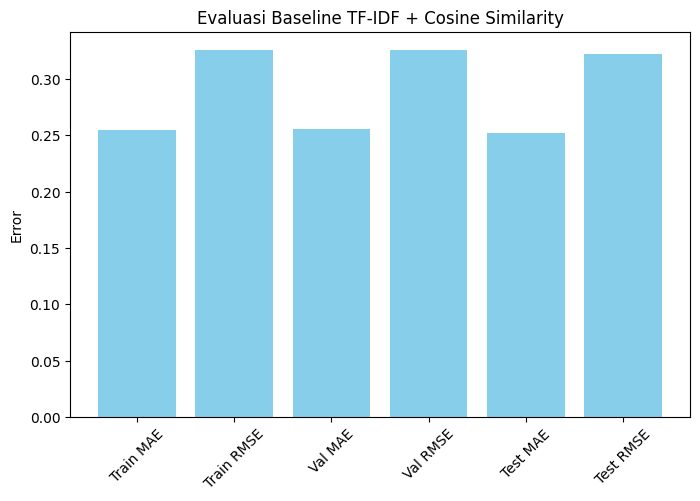

In [12]:
metrics = ["Train MAE", "Train RMSE", "Val MAE", "Val RMSE", "Test MAE", "Test RMSE"]
values = [train_mae, train_rmse, val_mae, val_rmse, test_mae, test_rmse]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color="skyblue")
plt.title("Evaluasi Baseline TF-IDF + Cosine Similarity")
plt.ylabel("Error")
plt.xticks(rotation=45)
plt.show()

In [13]:
save_path = "/content/drive/MyDrive/aes_tfidf_vectorizer.joblib"
joblib.dump(vectorizer, save_path)
print(f"Vectorizer berhasil disimpan ke: {save_path}")

metrics_df = pd.DataFrame({
    "Metric": metrics,
    "Value": values
})
metrics_path = "/content/drive/MyDrive/aes_tfidf_metrics.csv"
metrics_df.to_csv(metrics_path, index=False)
print(f"Metrik evaluasi berhasil disimpan ke: {metrics_path}")


Vectorizer berhasil disimpan ke: /content/drive/MyDrive/aes_tfidf_vectorizer.joblib
Metrik evaluasi berhasil disimpan ke: /content/drive/MyDrive/aes_tfidf_metrics.csv
